In [55]:
import pandas as pd
import importlib
from tqdm import tqdm
import os
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
df = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEnSHORT.csv",lineterminator='\n', nrows=50000)

<ipython-input-27-b28b5f302195>:1: DtypeWarning: Columns (6,7,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/shared/3/projects/benlitterer/podcastData/processed/floydMonth/floydMonthEnSHORT.csv",lineterminator='\n', nrows=50000)


In [28]:
spec=importlib.util.spec_from_file_location("getURLstorageLocation","/home/blitt/projects/podcasts/mergeTransMetadata/getURLstorageLocation.py")
# creates a new module based on spec
foo = importlib.util.module_from_spec(spec)
 
# executes the module in its own namespace
# when a module is imported or reloaded.
spec.loader.exec_module(foo)

In [29]:
META_PATH= "/shared/3/projects/benlitterer/podcastData/prosodyMerged/floydMonth"
df = df.dropna(subset=["enclosure"])
df["transcriptPath"] = df["enclosure"].apply(foo.getUrlTranscriptPath, args=[META_PATH])

<ipython-input-29-2b037169ee9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["transcriptPath"] = df["enclosure"].apply(foo.getUrlTranscriptPath, args=[META_PATH])


In [30]:
df["exists"] = df["transcriptPath"].apply(os.path.exists)

#foo.getUrlTranscriptPath("helloWorld", META_PATH) 
paths = df.loc[df["exists"] == True, "transcriptPath"] 

<ipython-input-30-f21d2ab468c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["exists"] = df["transcriptPath"].apply(os.path.exists)


In [31]:
finishedPaths = []
corpus = []
for path in tqdm(list(paths)): 
    try: 
        currFile = open(path, "r")
        currText = "".join([row.split(",")[4] for row in currFile.readlines()])
        corpus.append(currText)
    except Exception as e:
        print(e)
        pass

100%|██████████| 18286/18286 [01:08<00:00, 268.67it/s]


In [22]:
vectorizer = TfidfVectorizer(max_features=8000)
X = vectorizer.fit_transform(corpus)
tfIdfFeatures = X.toarray()

In [23]:
tfIdfNames = list(vectorizer.get_feature_names_out())

In [24]:
sum([True for item in tfIdfNames if item == "patreon" or item == "Patreon"])

1

In [95]:
vectorizer = CountVectorizer(max_features=20000)
X = vectorizer.fit_transform(corpus)
countFeatures = X.toarray()

In [96]:
countNames = list(vectorizer.get_feature_names_out())

In [97]:
countNames.index("patreon")

12920

In [98]:
sum(countFeatures[:,5119])
sum([item > 0 for item in countFeatures[:, 5119]])

1227

In [99]:
pca = PCA(n_components=2)

In [100]:
countFeatures.shape

(19069, 20000)

In [101]:
lFacs = pca.fit_transform(countFeatures)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_)

[0.45571762 0.08852809]
[36578.44717716  7105.75996726]


In [102]:
facsDf = df.loc[df["exists"] == True, ["epDescription", "duration", "category1", "category2"]] 

In [103]:
facsDf[["pc1", "pc2"]] = lFacs

In [104]:
catMeans = facsDf[["category1", "pc1", "pc2"]].groupby("category1").agg(np.mean)

In [105]:
catCounts = pd.DataFrame(facsDf["category1"].value_counts()).reset_index()
catMeans = pd.merge(catMeans, catCounts, how="left", on="category1")

Text(0, 0.5, 'PC2')

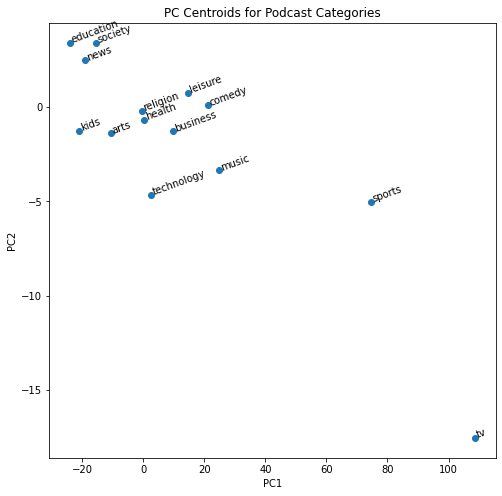

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
catMeans = catMeans[catMeans["count"] > 300]
ax.scatter(catMeans["pc1"], catMeans["pc2"])

for i, row in catMeans.iterrows(): 
    ax.annotate(row["category1"], (row["pc1"], row["pc2"]), rotation=20)

ax.set_title("PC Centroids for Podcast Categories")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

In [107]:
facsDf["category1"].value_counts()

category1
religion        3802
education       2638
business        2616
society         2083
news            1454
health          1307
arts            1030
sports           837
comedy           671
music            543
leisure          491
tv               353
kids             332
technology       304
science          158
fiction          139
history          129
government        73
true crime        47
games             14
spirituality       1
Name: count, dtype: int64

In [77]:
facsDf = pd.merge(facsDf, catCounts, on="category1", how="left")

In [108]:
commonCats = facsDf[facsDf["count"] > 300]
#commonCats = facsDf[facsDf["category1"].isin(["education", "sports"])]
fig, ax = plt.subplots(figsize=(8, 8))
#sns.scatterplot(data=facsDf[facsDf["category1"].isin(["comedy", "government"])], x="l1", y="l2", hue="category1", alpha=.2, ax=ax)
sns.scatterplot(data=commonCats, x="pc1", y="pc2", hue="category1", alpha=.3, ax=ax)

plt.xlim(-400, 500)
plt.ylim(-200, 200)

KeyError: 'count'

In [1]:
fig, ax = plt.subplots(0, figsize=(3, 9))
commonCats = facsDf[facsDf["count"] > 300]
sns.kdeplot(data=commonCats, x="pc1", hue="category1", common_norm=False)
plt.xlim(-500, 500)

NameError: name 'plt' is not defined